In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

sns.set()

In [157]:
# read in the sparse dataset
dataset = pd.read_csv(
		'../data/run-of-river_production_load_sparse.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime,
			"Date": pd.to_datetime
    })

dataset['epochdate'] = dataset['Date_Time'].map(pd.Timestamp.timestamp).astype(np.float32)
dataset_norm = dataset.drop(columns=['Date','Date_Time']).values
dataset_norm = (dataset_norm - dataset_norm.mean(0)) / dataset_norm.std(0)

/tmp/ipykernel_3212/3497461529.py:2: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  dataset = pd.read_csv(
/tmp/ipykernel_3212/3497461529.py:2: ParserWarning: Both a converter and dtype were specified for column Date - only the converter will be used.
  dataset = pd.read_csv(


In [158]:
# load the PowerEX predictions
predictions = pd.read_csv(
		'../data/mve_predictions_hourly_2022.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime
    })

predictions = predictions.drop_duplicates()

/tmp/ipykernel_3212/732643380.py:2: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  predictions = pd.read_csv(


In [159]:
# import the model torch.nn.Module
from all_S2S_models import S2S_BA_Model

In [160]:
def load_model(cell_type = 'lstm', window_source_size=168,window_target_size=48, hs = 24):
    # load the trained weights into the model
    
    
    checkpoint = torch.load(
        'tuning/models/MODEL_w:__seed=0_cell_type='+cell_type+ \
            '_attention_model=BA_la_method=none_T='+str(window_source_size)+ \
                '_N='+str(window_target_size)+'_bs=128_hs='+str(hs), \
                    map_location=torch.device('cpu'))

    model = S2S_BA_Model(cell_type, 44, hs, False)
    model.load_state_dict(checkpoint)

    return model

In [161]:
def get_predictions(model, start_index=18400, window_source_size=168, window_target_size=48):

    # retrieve range of dates for these indices
    dates = dataset['Date_Time'][start_index+window_source_size:start_index+window_source_size+window_target_size]

    # create the prediction (note the names of the functions may differ for your model)
    pred = model.predict(*model.consume(
        torch.from_numpy(np.array(
            [dataset_norm[start_index:start_index+window_source_size, :]]
        ))), window_target_size).detach().numpy().flatten()

    # extract the prediction arrays
    actual = dataset['Value'][start_index+window_source_size:start_index+window_source_size+window_target_size]
    preds = pred * dataset['Value'].std() + dataset['Value'].mean()
    powerex = predictions[np.logical_and(predictions['Date_Time'] >= dates.min(), predictions['Date_Time'] <= dates.max())]

    return dates, actual, preds, powerex

In [172]:
def get_error_metrics(actual, pred, title="ERRORS"):
    mae = (sum(abs(actual - pred)))/(len(actual))
    mape = (sum(abs((actual - pred)/actual))) / (len(actual))
    smape = (sum(abs(actual - pred)/(abs(actual)+abs(pred)))) / (len(actual))
    rmse = np.sqrt(np.mean((actual - pred)**2))

    print("\n###### "+title+" ######")
    print("MAE:", mae)
    print("MAPE:", mape*100.0,"%")
    print("SMAPE:", smape*100.0,"%")
    print("RMSE:", rmse)

    return mae, mape, smape, rmse


###### ACTUAL VS S2S (lstm) ######
MAE: 447.8738657633464
MAPE: 71.9626167944322 %
SMAPE: 24.883629670754694 %
RMSE: 490.50195

###### ACTUAL VS S2S (gru) ######
MAE: 317.39441299438477
MAPE: 47.920971969142556 %
SMAPE: 18.993446040743343 %
RMSE: 385.7405

###### ACTUAL VS S2S (rnn) ######
MAE: 260.14768981933594
MAPE: 35.09991004830226 %
SMAPE: 15.8080097908775 %
RMSE: 360.53076

###### ACTUAL VS POWEREX ######
MAE: 316.3655548095703
MAPE: 47.748398925371774 %
SMAPE: 18.889436644773618 %
RMSE: 387.2167


(316.3655548095703, 0.47748398925371777, 0.1888943664477362, 387.2167)

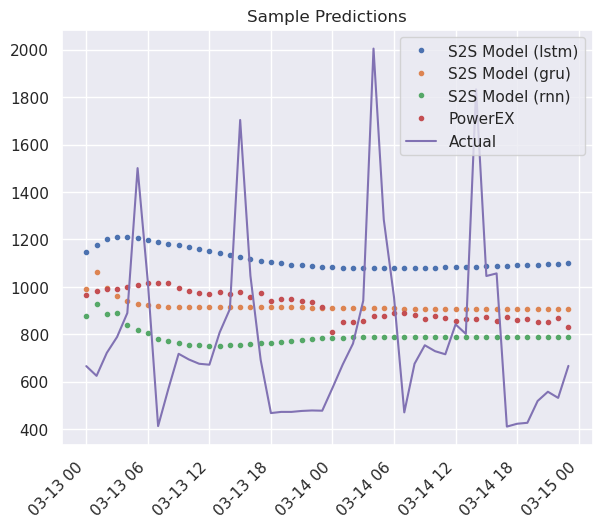

In [182]:
for cell_type in ['lstm', 'gru', 'rnn']:
    model = load_model(cell_type, 48, 48, 48)

    dates, actual, preds, powerex = get_predictions(model, 19200, 48, 48)
    plt.plot(dates, preds, '.', label='S2S Model ({})'.format(cell_type))

    get_error_metrics(actual, preds, "ACTUAL VS S2S ({})".format(cell_type))
   
plt.plot(powerex['Date_Time'], powerex['prediction'], '.', label='PowerEX')
plt.plot(dates, actual, label='Actual')

# plot formatting
plt.legend()
plt.gcf().tight_layout()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Sample Predictions")

actual_powerex = dataset.set_index('Date_Time').loc[powerex['Date_Time']]['Value'].values
get_error_metrics(actual_powerex, powerex['prediction'], "ACTUAL VS POWEREX")

In [185]:
%%capture
cell_type = 'lstm'
model = load_model(cell_type, 168, 48, 48)
model_errors = []
powerex_errors = []
for i in range(17546, 20000):
    dates, actual, preds, powerex = get_predictions(model, i, 168, 48)
    model_errors.append(list(get_error_metrics(actual, preds, "ACTUAL VS MODEL")))
    actual_powerex = dataset.set_index('Date_Time').loc[powerex['Date_Time']]['Value'].values
    powerex_errors.append(list(get_error_metrics(actual_powerex, powerex['prediction'], "ACTUAL VS POWEREX")))

Model Mean MAE 447.522591243973
PowerEX Mean MAE 385.03284231969974


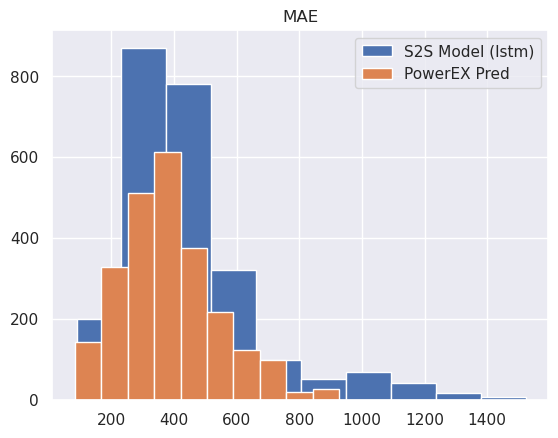

Model Mean MAPE 1.2183627092785803
PowerEX Mean MAPE 1.1572013199706028


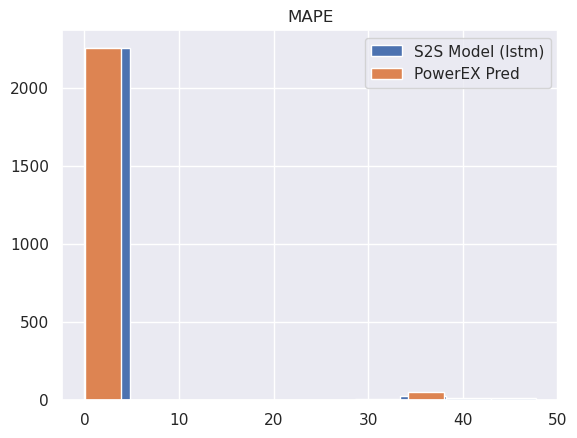

Model Mean SMAPE 0.17707375294493002
PowerEX Mean SMAPE 0.153380709064414


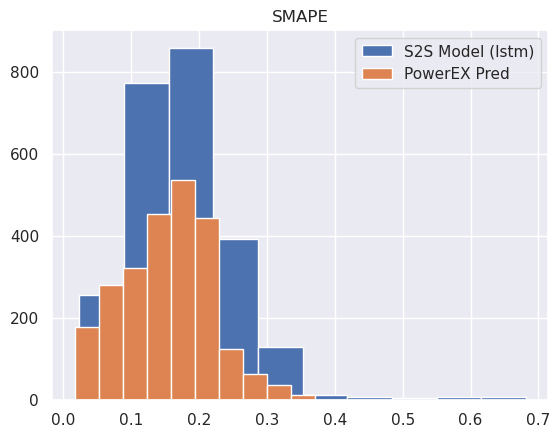

Model Mean RMSE 519.94183
PowerEX Mean RMSE 464.4177


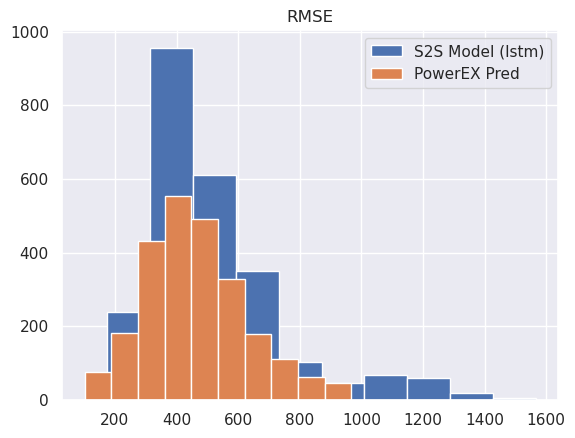

In [186]:
errors = ["MAE", "MAPE", "SMAPE", "RMSE"]
df_model = pd.DataFrame.from_records(model_errors, columns=errors).replace([np.inf, -np.inf], np.nan)
df_powerex = pd.DataFrame.from_records(powerex_errors, columns=errors).replace([np.inf, -np.inf], np.nan)

for error in errors:
    print("Model Mean", error, df_model[error].mean())
    print("PowerEX Mean", error, df_powerex[error].mean())
    plt.hist(df_model[error], 10, label="S2S Model ("+cell_type+")")
    plt.hist(df_powerex[error], 10, label="PowerEX Pred")
    plt.legend()
    plt.title(error)
    plt.show()